In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Ensures that the display width isn't restricted
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [5]:
scan = set(['ipsweep', 'portsweep', 'nmap', 'satan'])
dos = set(['neptune', 'smurf', 'pod', 'teardrop', 'land'])
access = set(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezclient', 'warezmaster'])
exploit = set(['buffer_overflow', 'loadmodule', 'rootkit', 'perl'])
backdoor = set(['back','spy'])

df['attack_category'] = None

for i in range(len(df)):
  attk = df.loc[i,'attack']
  if attk in scan:
    df.loc[i,'attack_category'] = 'scan'
  elif attk in dos:
    df.loc[i,'attack_category'] = 'dos'
  elif attk in access:
    df.loc[i,'attack_category'] = 'access'
  elif attk in exploit:
    df.loc[i,'attack_category'] = 'exploit'
  elif attk in backdoor:
    df.loc[i,'attack_category'] = 'backdoor'
  else:
    df.loc[i,'attack_category'] = 'normal'

In [6]:
# Host count of flags
df['serror'] = df['count']*df['serrorrate']
df['rerror'] = df['count']*df['rerrorrate']

# Host srv count of flags
df['srvserror'] = df['srvcount']*df['srvrerrorrate']
df['srvrerror'] = df['srvcount']*df['srvserrorrate']

df['samesrv'] = df['count']*df['samesrvrate']
df['diffsrv'] = df['count']*df['diffsrvrate']

# Host count of flags
df['dsthostserror'] = df['dsthostcount']*df['dsthostserrorrate']
df['dsthostrerror'] = df['dsthostcount']*df['dsthostrerrorrate']

# Host srv count of flags
df['dsthostsrvserror'] = df['dsthostsrvcount']*df['dsthostsrvrerrorrate']
df['dsthostsrvrerror'] = df['dsthostsrvcount']*df['dsthostsrvserrorrate']

df['dsthostsamesrv'] = df['dsthostsrvcount']*df['dsthostsamesrvrate']
df['dsthostdiffsrv'] = df['dsthostsrvcount']*df['dsthostdiffsrvrate']

In [7]:
X = df.drop(['attack','is_attack','attack_category'],axis=1)
y = df['is_attack']

In [8]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=df['attack_category'],random_state=42)

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag','land','wrongfragment','urgent','numfailedlogins','loggedin','rootshell','suattempted','numshells',
                       'ishostlogin','isguestlogin']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [10]:
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [11]:
from sklearn.ensemble  import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced',random_state=42,max_depth=30,
                       min_samples_split=5, n_estimators=200,)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [12]:
y_pred = rf.predict(X_test)

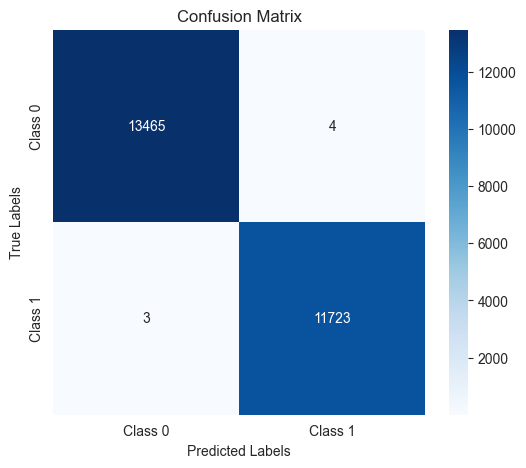

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=['normal','attack']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     13469
      attack       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



In [15]:
y_pred_df = pd.DataFrame(y_pred,index=y_test.index)
combined_pred = pd.concat([y_test,y_pred_df],axis=1)
combined_pred.columns = ['is_attack','is_attack_pred']
predicted_probabilities = rf.predict_proba(X_test)
combined_pred['predict_prob'] = predicted_probabilities[:, 1]

In [16]:
combined_pred[np.logical_and(combined_pred['is_attack'] == combined_pred['is_attack_pred'],combined_pred['is_attack'] == 1)].sort_values(by='predict_prob').head()

,is_attack,is_attack_pred,predict_prob
100281,1,1,0.518817
66013,1,1,0.532964
120844,1,1,0.542411
65938,1,1,0.591682
6004,1,1,0.592232


In [20]:
combined_pred[np.logical_and(combined_pred['is_attack'] != combined_pred['is_attack_pred'],combined_pred['is_attack'] != 1)]

,is_attack,is_attack_pred,predict_prob
16515,0,1,0.916184
112222,0,1,0.562226
63360,0,1,0.694388
109088,0,1,0.627485


In [17]:
fp = combined_pred[np.logical_and(combined_pred['is_attack'] != combined_pred['is_attack_pred'],combined_pred['is_attack'] != 1)]
fn = combined_pred[np.logical_and(combined_pred['is_attack'] != combined_pred['is_attack_pred'],combined_pred['is_attack'] == 1)]

In [18]:
df[df.index.isin(fp.index)]

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack,attack_category,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv
16515,0,icmp,ecr_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.00,0.00,1.0,0.00,0.0,0.00,0.0,0.0,normal,14,0,normal,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0
63360,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,240,0.94,0.01,0.0,0.00,0.0,0.00,0.0,0.0,normal,10,0,normal,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,225.6,2.4
109088,0,tcp,ftp_data,SF,0,2072,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,42,1.00,0.00,1.0,0.05,0.0,0.00,0.0,0.0,normal,9,0,normal,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,42.0,0.0
112222,0,tcp,finger,S0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1,11,1.00,0.00,1.0,0.27,1.0,0.09,0.0,0.0,normal,8,0,normal,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.99,11.0,0.0


In [19]:
df[df.index.isin(fn.index)]

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack,attack_category,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv
21445,299,tcp,telnet,SF,112,847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,48,0.19,0.02,0.00,0.0,0.22,0.31,0.0,0.0,spy,9,1,backdoor,0.0,0.0,0.0,0.0,1.0,0.0,56.1,0.0,0.0,14.88,9.12,0.96
57361,1,tcp,private,RSTOS0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.5,0.5,0.5,0.5,1.0,0.0,0.0,255,2,0.01,0.01,0.01,0.0,0.00,0.50,0.0,0.5,portsweep,20,1,scan,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.00,0.02,0.02
69942,0,tcp,ftp_data,SF,0,5636,0,0,0,0,0,1,2,0,0,2,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,41,1.00,0.00,1.00,0.1,0.00,0.00,0.0,0.0,rootkit,7,1,exploit,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,41.00,0.00


In [21]:
probability = rf.predict_proba(X_test)
probabilites = probability[:,1]

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thr = roc_curve(y_test,probabilites)

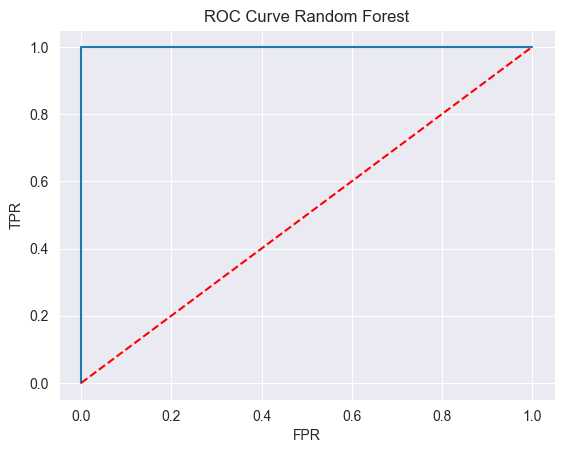

In [23]:
plt.plot(fpr,tpr)

plt.plot(fpr,fpr,'--',color='red' )
plt.title('ROC Curve Random Forest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [24]:
rf_score = roc_auc_score(y_test,probabilites)
rf_score

np.float64(0.9999987210130103)

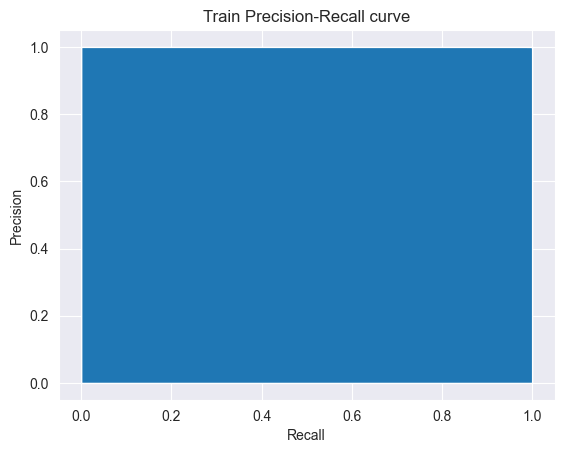

In [31]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test,probabilites)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");